# Loan Repayment Model

Throughout our analysis of the PPP data, we anchored our focus around what happened during the loan program. Who received the loans, how did they use it, was there a connection to unemployment rates? For machine learning, we shifted from focusing on what the loan program was like in practice to how to optimize future implementation of a similar program.
Throughout the course of the Paycheck Protection Program, the US government forgave $742 billion of the $793 billion of loans dispersed. Given the large scale of the PPP data (over 11 million total loans), this still left a meaningful number of unforgiven loans. For our predictive modeling, our group decided created a model that predicts whether or not a borrower will pay back their loan based on key information including the industry, age of the business, and the demographics of the owner.

Importing key libraries for SQL import, visualizations, and model

In [22]:
#import libraries
import pymssql
import dash
from dash import dcc
from dash import dcc, html
import plotly.express as px
import plotly.graph_objects as go

import profile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, matthews_corrcoef, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, RFECV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

In [23]:
database = "group-2-capstone"
username = "group_2"
password  = 'Sp0ngeB0b'
server = "gen10-data-fundamentals-22-07-sql-server.database.windows.net"
port = "1433"

In [ ]:
#import SQL server
from config import database
from config import username
from config import password
from config import server

In [24]:
#table variables
PPPLoanInfo = "dbo.PPPLoanInfo"
PPPLender = 'dbo.PPPLender'
Unemployment = 'dbo.Unemployment'
CensusInfo = "dbo.CensusInfo"
PPPBorrower = "dbo.PPPBorrower"
State = "dbo.State"
Industry = "dbo.Industry"
DemographicInfo = 'dbo.DemographicInfo'
BusinessAgeDescription = 'dbo.BusinessAgeDescription'
BusinessType = 'dbo.BusinessType'

In [25]:
#connection variables
conn = pymssql.connect(server,username, password,database)
cursor = conn.cursor()

In order to provide the machine learning algorithm a meaningful dataset, we are taking a few steps to clean our data. First, we are importing target rows from our SQL database. We selected these rows based on analysis of the original PPP data. We're filtering out where Race, Ethnicity, Sex, Business Age Description, and State Name are unanswered.

In [7]:
#sql query
ml_query = f'''select distinct LoanNumber, 
LoanStatus, 
BusinessAgeDescription, 
BusinessTypeDescription, 
Race, 
Ethnicity, 
Sex,
IndustryName,
StateName,
HubzoneIndicator,
LMIIndicator,
sum(CurrentApprovalAmount) as CurrentApprovalAmount, 
sum(ForgivenessAmount) as ForgivenessAmount
from {PPPLoanInfo}
join {PPPBorrower} on PPPLoanInfo.PPPBorrowerID = PPPBorrower.PPPBorrowerID
join {BusinessAgeDescription} on PPPBorrower.BusinessAgeDescID = BusinessAgeDescription.BusinessAgeDescID
join {BusinessType} on PPPBorrower.BusinessTypeID = BusinessType.BusinessTypeID
join {CensusInfo} on PPPBorrower.CensusID = CensusInfo.CensusID
join {DemographicInfo} on CensusInfo.DemographicID = DemographicInfo.DemographicID
join {Industry} on CensusInfo.IndustryID = Industry.IndustryID
join {State} on CensusInfo.StateID = [State].[StateID]
where Race not like '%Unanswered%'
and Ethnicity not like '%Unanswered%'
and Sex not like '%Unanswered%'
and BusinessAgeDescription not like '%Unanswered%'
and StateName not like '%Unanswered%'
group by HubzoneIndicator, LMIIndicator, LoanStatus, Ethnicity, Sex, BusinessAgeDescription, Race, IndustryName, BusinessTypeDescription, StateName, LoanNumber
order by LoanNumber'''

In [27]:
#read in sql query
ml_df = pd.read_sql(ml_query, conn)

After the SQL import, we're checking a few metrics to ensure that the data imported correctly. It all looks good!

In [28]:
#checking DF
ml_df.shape

(1510537, 13)

In [29]:
#checking DF - this is a key metric that will indicate if the distribution of this data set is accurate to our original PPP loan dataset
ml_df['Race'].value_counts()

White                        928939
Black or African American    429616
Asian                        151982
Name: Race, dtype: int64

In order filter our data down to only loans with an outstanding balance, we're creating a column, difference, that captures the difference between the amount of money loaned to the borrower and the amount of money forgiven and then filtering our data frame so that only loans with an outstanding balance remain.

In [30]:
#creating a column to determine if a business's loans were entirely forgiven
ml_df['Difference'] = ml_df['CurrentApprovalAmount'] - ml_df['ForgivenessAmount']

#filtering out loans that were entirely forgiven
unpaid = ml_df['Difference'] > 0
remaining_balance_df = ml_df[unpaid].copy()
remaining_balance_df.drop(columns='Difference', inplace=True)

Machine learning models need to work with numerical data. We're creating dummy variables on all categorcal columns in order to create a our algorithm.

In [31]:
df = pd.get_dummies(remaining_balance_df, columns=['StateName', 'LoanStatus', 'Race', 'Ethnicity', 'BusinessTypeDescription', 'BusinessAgeDescription','Sex', 'IndustryName','HubzoneIndicator','LMIIndicator'], drop_first=True)

Our target row for this model is ‘Loan Status.’ According to the PPP data dictionary, a loan is either labeled as ‘Paid in Full’ or ‘Exemption 4.’ The Small Business Administration defines Exemption 4 as “when the loan is disbursed but not Paid in Full or Charged Off.” Therefore, of the loans with an outstanding balance, the loan status tells us whether or not a business has fully paid their loan.

Our x data set will include all columns execpt for our target, the Loan Status. Our y stat set will include only the loan status column.

In [32]:
#creating X and Y tables
x = df.copy().drop(columns='LoanStatus_Paid in Full')
y = df.copy()['LoanStatus_Paid in Full']

We are using the stratify feature here to ensure that the distribution of Exemption 4 to Paid in Full is the same as in the data set. This will ensure that our model is working with an accurate subset of the data.

In [33]:
#creating sets for model
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=df['LoanStatus_Paid in Full'],random_state=1)

Printing the train and test sets to make sure everything looks accurate!

In [34]:
#checking sets
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (38877, 96) (38877,)
Test (9720, 96) (9720,)


We will use K Nearest Neighbors for our model. More explanation of the algorithm is below when we implement the model.

Given that KNN classifies a point based on its proximity to other points, we are standardizing our data by running the standard scaler feature on our X train and test data sets. 

In [35]:
#scaling data for KNN model
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In order to determine the variance of features and understand their importance to the model, we're running ANOVA tests on all features. While the results are slightly harder to interpret as most features are represented as dummy variables, we are using this to understand broader categories and their importance.

Feature 0: 0.000712
Feature 1: 216.575704
Feature 2: 66.747099
Feature 3: 4.322884
Feature 4: 1.377234
Feature 5: 12.782956
Feature 6: 117.290194
Feature 7: 5.430955
Feature 8: 2.698052
Feature 9: 5.570238
Feature 10: 149.626546
Feature 11: 32.545287
Feature 12: 1.670474
Feature 13: 3.396558
Feature 14: 12.015473
Feature 15: 28.638986
Feature 16: 84.586442
Feature 17: 89.652323
Feature 18: 18.672558
Feature 19: 34.003319
Feature 20: 16.980111
Feature 21: 13.961869
Feature 22: 0.054673
Feature 23: 4.616929
Feature 24: 54.516639
Feature 25: 21.607631
Feature 26: 29.818636
Feature 27: 47.199878
Feature 28: 111.855560
Feature 29: 7.558782
Feature 30: 18.290332
Feature 31: 62.865035
Feature 32: 0.455305
Feature 33: 460.231898
Feature 34: 2.313746
Feature 35: 42.541540
Feature 36: 40.454575
Feature 37: 40.892714
Feature 38: 1.886605
Feature 39: 3.493840
Feature 40: 5.054370
Feature 41: 0.311147
Feature 42: 46.896564
Feature 43: 4.165804
Feature 44: 4.242699
Feature 45: 0.720706
Feature 46: 1

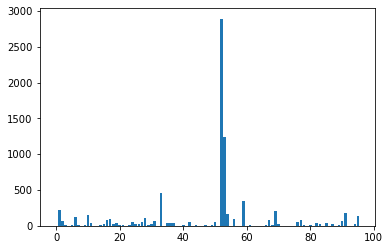

In [36]:
def anova_select_features(X_train, y_train, X_test):
    # configure to select all features
    afs = SelectKBest(score_func=f_classif, k='all')

    # learn relationship from training data
    afs.fit(X_train, y_train)

    # transform train and test input data
    X_train_fs = afs.transform(X_train)
    X_test_fs = afs.transform(X_test)

    return X_train_fs, X_test_fs, afs

X_train_fs, X_test_fs, afs = anova_select_features(X_train, y_train, X_test)

for i in range(len(afs.scores_)):
    print('Feature %d: %f' % (i, afs.scores_[i]))

#prints bar chart, this doens't help too much as we have a ton of features
plt.bar([i for i in range(len(afs.scores_))], afs.scores_)
plt.show()

In [37]:
#printing out a list to make a little more sense of important features
index_values = ['LoanNumber', 'CurrentApprovalAmount', 'ForgivenessAmount',
       'StateName_Alaska', 'StateName_Arizona', 'StateName_Arkansas',
       'StateName_California', 'StateName_Colorado', 'StateName_Connecticut',
       'StateName_Delaware', 'StateName_Florida', 'StateName_Georgia',
       'StateName_Hawaii', 'StateName_Idaho', 'StateName_Illinois',
       'StateName_Indiana', 'StateName_Iowa', 'StateName_Kansas',
       'StateName_Kentucky', 'StateName_Louisiana', 'StateName_Maine',
       'StateName_Maryland', 'StateName_Massachusetts', 'StateName_Michigan',
       'StateName_Minnesota', 'StateName_Mississippi', 'StateName_Missouri',
       'StateName_Montana', 'StateName_Nebraska', 'StateName_Nevada',
       'StateName_New Hampshire', 'StateName_New Jersey',
       'StateName_New Mexico', 'StateName_New York',
       'StateName_North Carolina', 'StateName_North Dakota', 'StateName_Ohio',
       'StateName_Oklahoma', 'StateName_Oregon', 'StateName_Pennsylvania',
       'StateName_Rhode Island', 'StateName_South Carolina',
       'StateName_South Dakota', 'StateName_Tennessee', 'StateName_Texas',
       'StateName_Utah', 'StateName_Vermont', 'StateName_Virginia',
       'StateName_Washington', 'StateName_West Virginia',
       'StateName_Wisconsin', 'StateName_Wyoming',
       'Race_Black or African American', 'Race_White',
       'Ethnicity_Non-Hispanic', 'BusinessTypeDescription_Cooperative',
       'BusinessTypeDescription_Corporation',
       'BusinessTypeDescription_Employee Stock Ownership Plan(ESOP)',
       'BusinessTypeDescription_Housing Co-op',
       'BusinessTypeDescription_Independent Contractors',
       'BusinessTypeDescription_Joint Venture',
       'BusinessTypeDescription_Limited  Liability Company(LLC)',
       'BusinessTypeDescription_Limited Liability Partnership',
       'BusinessTypeDescription_Non-Profit Childcare Center',
       'BusinessTypeDescription_Non-Profit Organization',
       'BusinessTypeDescription_Partnership',
       'BusinessTypeDescription_Professional Association',
       'BusinessTypeDescription_Self-Employed Individuals',
       'BusinessTypeDescription_Single Member LLC',
       'BusinessTypeDescription_Sole Proprietorship',
       'BusinessTypeDescription_Subchapter S Corporation',
       'BusinessTypeDescription_Trust',
       'BusinessAgeDescription_Existing or more than 2 years old',
       'BusinessAgeDescription_New Business or 2 years or less',
       'BusinessAgeDescription_Startup, Loan Funds will Open Business',
       'Sex_Male',
       'IndustryName_Administrative and Support and Waste Management and Remediation Services',
       'IndustryName_Agriculture, Forestry, Fishing and Hunting',
       'IndustryName_Arts, Entertainment, and Recreation',
       'IndustryName_Construction', 'IndustryName_Educational Services',
       'IndustryName_Finance and Insurance',
       'IndustryName_Health Care and Social Assistance',
       'IndustryName_Information',
       'IndustryName_Management of Companies and Enterprises',
       'IndustryName_Manufacturing', 'IndustryName_Mining',
       'IndustryName_Other Services (except Public Administration)',
       'IndustryName_Professional, Scientific, and Technical Services',
       'IndustryName_Real Estate Rental and Leasing',
       'IndustryName_Retail Trade',
       'IndustryName_Transportation and Warehousing', 'IndustryName_Utilities',
       'IndustryName_Wholesale Trade', 'HubzoneIndicator_Y', 'LMIIndicator_Y']

feature_data = {'Feature': index_values,
              'Anova_Score': afs.scores_}

featureDF = pd.DataFrame(feature_data)

sorted_features = featureDF.sort_values(by='Anova_Score', ascending=False)

We've taken the results of a test and put them in a data frame. Below, we're looking at a printout of all the features and their score.

We're using this information to determine if there are any columns we should drop. For example, StateName_NewYork is a factor with a relatively higher ANOVA score, so that provides us rationale for keeping all state variables in the model. However, any variable tied to BusinessAgeDescription only begins to show up at the bottom of the list, which leads us to determine that we should remove it from the model.

In [38]:
#display these features
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(sorted_features)

                                              Feature  Anova_Score
52                     Race_Black or African American    2.893e+03
53                                         Race_White    1.241e+03
33                                 StateName_New York    4.602e+02
59    BusinessTypeDescription_Independent Contractors    3.526e+02
1                               CurrentApprovalAmount    2.166e+02
69        BusinessTypeDescription_Sole Proprietorship    2.097e+02
91        IndustryName_Transportation and Warehousing    1.850e+02
54                             Ethnicity_Non-Hispanic    1.592e+02
10                                  StateName_Florida    1.496e+02
95                                     LMIIndicator_Y    1.362e+02
6                                StateName_California    1.173e+02
28                                 StateName_Nebraska    1.119e+02
56                BusinessTypeDescription_Corporation    9.807e+01
17                                   StateName_Kansas    8.965

Based on the results, we're dropping loan number and business age description from the model, and then recreating train and test sets with the new data frame.

In [39]:
remaining_balance_df.drop(columns = ['LoanNumber','BusinessAgeDescription'], inplace=True)

df = pd.get_dummies(remaining_balance_df, columns=['StateName', 'LoanStatus', 'Race', 'Ethnicity', 'BusinessTypeDescription','Sex', 'IndustryName','HubzoneIndicator','LMIIndicator'], drop_first=True)
x = df.copy().drop(columns='LoanStatus_Paid in Full')
y = df.copy()['LoanStatus_Paid in Full']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=df['LoanStatus_Paid in Full'],random_state=1)
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

Before starting to tune the hyperparameters, we're running the base KNN model to get an idea of performance and where we might want to tune. We selected KNN because based on preliminary tests using the base model and a subset of our data, it had the best test and train accuracy. K-Nearest Neighbors can be used for both classification and regression analysis, although the former is more common. In classification analysis, the algorithm determines a class for a target data point based on the class of the k nearest neighbors. K is a hyperparameter selected by the user. The other main hyperparameter is the formula the algorithm uses to measure the distance between points.

In [ ]:
#running base model with no tuning
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)

KNeighborsClassifier()

The base model has decent performance, with a train accuracy of 0.9 (90% accurate), and a test accuracy of 0.87 (87% accuracy).

In [27]:
#accuracy scores
print(f'Train Accuracy: {classifier.score(X_train,y_train):.3f}')
print(f'Test Accuracy: {classifier.score(X_test,y_test):.3f}')

Train Accuracy: 0.904
Test Accuracy: 0.874


Based on the confusion matrix, we can see that the model will predict a false positive (that someone will pay back their loan when they probably won't) about 9.6% of the time, and will predict a false negative (that someone won't pay back their loan when they probably will) about 3% of the time. Given that this model would be used in a scenario where a lender is trying to reduce their financial risk, we'll try to reduce the false positive rate with tuning.

In [28]:
#confusion matrix
y_pred = classifier.predict(X_test)
y_pred
cm = confusion_matrix(y_test, y_pred)
print (cm)
print(f1_score(y_test, y_pred))

[[ 289  934]
 [ 295 8202]]
0.9303011399081268


The first tuning metric we're using is a grid search. Here, SKLearn runs the model with a variety of parameters to determine the optimal parameters for a specific model. We're having the grid search run the model with a list of neighbors between 50 and 500, increasing in increments of 50. We're also testing a variety of distance equations to see which one gets us the best performance.

In [40]:
#grid search to opitmize parameters

# Create a list for number of trees between 20 and 300 and going up by 50
neighbors = []
for i in range(50,500,50):
    neighbors.append(i)

# Specify the parameters to test
param_grid = {
    'n_neighbors': neighbors,
    'metric': ['chebyshev', 'cityblock', 'euclidean', 'infinity', 'l1', 'l2', 'manhattan', 'minkowski', 'p']
}

# Create a model
knn = KNeighborsClassifier()

#Use grid search
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid)

In [41]:
#fit grid search
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['chebyshev', 'cityblock', 'euclidean',
                                    'infinity', 'l1', 'l2', 'manhattan',
                                    'minkowski', 'p'],
                         'n_neighbors': [50, 100, 150, 200, 250, 300, 350, 400,
                                         450]})

According to the grid search, the optimal parameters for our model (within the specifications provided) are k = 50 and the city block equation.

In [ ]:
#find optimal parameters
grid_search.best_params_

{'metric': 'cityblock', 'n_neighbors': 50}

In [32]:
#fit model with grid search optimal parameters
classifier = KNeighborsClassifier(metric = 'cityblock', n_neighbors = 50)
classifier.fit(X_train, y_train)

KNeighborsClassifier(metric='cityblock', n_neighbors=50)

When we fit this model based on the grid search, we can see a decrease in accuracy and an increase in false positives compared to the base model.

In [33]:
print(f'Train Accuracy: {classifier.score(X_train,y_train):.3f}')
print(f'Test Accuracy: {classifier.score(X_test,y_test):.3f}')

Train Accuracy: 0.883
Test Accuracy: 0.885


In [34]:
#print confusion matrix
y_pred = classifier.predict(X_test)
y_pred
cm = confusion_matrix(y_test, y_pred)
print (cm)
print(f1_score(y_test, y_pred))

[[ 140 1083]
 [  36 8461]]
0.9379746133806329


Given that the grid search didn't improve our performance, we're trying another method to find the optimal number for K. Based on time/processing restrictions, the grid search ran in iterations of 50. This search method looking only at k allows us to search in increments of 1. Since the grid search chose k = 50, the lowest number available, we're going to look at 1-50 to find the optimal number for k.

This method runs the KNN algorithm with a list of numbers that we provide and then prints the accuracy score.

In [44]:
k_values = np.arange(1, 50)
cross_validation_fold = 10
accuracies = []

In [45]:
accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x, y, cv=cross_validation_fold, scoring='accuracy', n_jobs=-1)
    accuracies.append(scores.mean())
print(accuracies)

[0.9056736555219324, 0.8615969178572366, 0.874560482139545, 0.8627490203152777, 0.8775647498130406, 0.8725439661838326, 0.8771532271792957, 0.8725850464582713, 0.8768444581646888, 0.8739430669149861, 0.8785112349320805, 0.8756509747725362, 0.8779349338591066, 0.8759801208905962, 0.8787169411985903, 0.8773794375885571, 0.8787580892273216, 0.8776880837985089, 0.8789638590134805, 0.8780379288529113, 0.8793547970462516, 0.8785111756470746, 0.8795399652928637, 0.8792107133087217, 0.8799515090998249, 0.8792107641244409, 0.8790255408274662, 0.8788609444778981, 0.8796017275650716, 0.8793136151403742, 0.8799720894661555, 0.8797663027414233, 0.8797868619345375, 0.8794987960909161, 0.8796839770414581, 0.8798692172770058, 0.8799103483671639, 0.8798074677087276, 0.8799926655978426, 0.879930954141354, 0.8797663154453532, 0.8796222528810395, 0.8796634305522737, 0.8797045743463616, 0.8795399610582203, 0.8796222528810397, 0.8800337882187144, 0.8797251462434057, 0.879992652893913]


Based on this graph, we can see that we're getting the highest accuracy score with 1 neighbor.

Text(0.5, 0.98, 'kNN hyperparameter (k) tuning with sklearn')

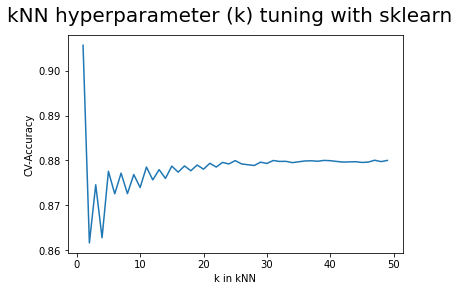

In [46]:
fig2 = plt.figure()
plt.plot(k_values, accuracies)
plt.xlabel('k in kNN')
plt.ylabel('CV-Accuracy')
fig2.suptitle('kNN hyperparameter (k) tuning with sklearn', fontsize=20)

Now we'll fit the model with 1 neighbor to check the accuracy and confusion matrix.

In [23]:
classifier = KNeighborsClassifier(metric = 'cityblock', n_neighbors = 1)
classifier.fit(X_train, y_train)

KNeighborsClassifier(metric='cityblock', n_neighbors=1)

Based on these results, this model could potentially be overfit, with a train accuracy of 1. However, the test accuracy is lower, showing that the model isn't necessarly overfitting the results. 

Looking at the confusion matrix, we have reduced our false positives to 5.9%, which is ideal for the purposes of a loan model. Therefore, this is the optimal model for this data.

In [48]:
print(f'Train Accuracy: {classifier.score(X_train,y_train):.3f}')
print(f'Test Accuracy: {classifier.score(X_test,y_test):.3f}')

Train Accuracy: 1.000
Test Accuracy: 0.885


In [49]:
#print confusion matrix
y_pred = classifier.predict(X_test)
y_pred
cm = confusion_matrix(y_test, y_pred)
print (cm)
print(f1_score(y_test, y_pred))

[[ 647  576]
 [ 546 7951]]
0.934093045112782
